In [342]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090a_hw1.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090A Introduction to Data Science
## Homework 1: Webscraping, Pandas, and EDA

**Harvard University**<br/>
**Fall 2024**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, and Chris Gumb

<hr style="height:2.4pt">

In [343]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
# import pyarrow as pa # optional
import seaborn as sns
import matplotlib.pyplot as plt
import re
import io
import os.path
import json
import time
import glob
from datetime import datetime, timedelta
# import asyncio # optional
# import aiohttp # optional
from IPython.core.display import HTML
from IPython import display

In [10]:
# For calculating total notebook runtime
notebook_start = time.time()

In [11]:
style = '''<style>
h3, h4 {
    background-color: #7efcf5;
    border-left: 5px solid #7ec4fc;
    border-right: 5px solid #7ec4fc;
    padding: 0em;
}
h3 {
    background-color: #7efcf5;
    border-top: 5px solid #7ec4fc;
    border-left: 5px solid #7ec4fc;
    border-right: 5px solid #7ec4fc;
    padding: 0.5em;
}
p {
    padding: 0.5em;
    max-width: 34em;
    font-weight:400;
}
.md {
    max-width: 80ch;

}
.prompt {    
    background-color: lightgreen;
    border-color: #dFb5b4;
    border-left: 5px solid #f57efc;
    padding: 0.5em;
    font-weight:500;
    }
 </style>'''
HTML(style)

## Assignment Overview

You'll be working with data from screenboston.com, a website that aggregates movie screenings from various theaters in the Boston area. Your task is to collect this data, enrich it with information from Wikipedia, and then analyze and visualize the results.

## Assignment Structure

The assignment is divided into 8 main questions, each building upon the previous ones, followed by a wrap-up:

1. Fetching HTML from screenboston.com (10 pts)
2. Parsing HTML into structured data (15 pts)
3. Augmenting data with historical snapshots (15 pts)
4. Creating and manipulating a Pandas DataFrame (15 pts)
5. Initial exploratory data analysis and visualization (15 pts)
6. Finding Wikipedia pages for each screened film (7 pts)
7. Storing Wikipedia HTML in the DataFrame (3 pts)
8. Extracting and analyzing data from Wikipedia pages (15 pts)
9. Wrap-up (5 pts)

As you progress through these steps, you'll be transforming raw web data into a rich dataset ready for analysis. By the end, you'll have created a comprehensive overview of Boston's movie screening landscape, potentially uncovering interesting trends and patterns in the process. 

<div style = "border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should include labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output. Or better yet, avoid overly long output altogether.
- Feel free to add additional code or markdown cells as needed.
- Don't forget to include a written response when one is requested by a question prompt.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>


<div class=md>
<h3>1. Getting HTML from screenboston.com</h3>

<p>Our first step is to get the HTML content from the page at screenboston.com for analysis. To avoid having to make unnecessary future requests, you should write the content to disk.</p>



<div class=prompt>
    
1. Use the `requests` library to get the html located at screenboston.com.
1. Save it in the file `data/html/screenboston.html`.

**Your code should only make an HTTP request if the file does not already exist.** 

**Hint:** the `os.path.isfile()` function can be used check if a file exists.
</div>
</div>


In [396]:
pd.set_option('display.max_colwidth', 50)  # Display full content without truncation

In [318]:

# your code here

movie_url = "https://www.screenboston.com"
path = "data/html/"

# create subdirectory
os.makedirs(os.path.dirname(path), exist_ok=True)

# check if file in subdirectory exists and then get text
if not os.path.isfile(f"{path}screenboston.html"):
    response = requests.get(movie_url)
    response.encoding = 'utf-8'
    with open(f"{path}screenboston.html", "w") as file:
        file.write(response.text)

In [109]:
grader.check("q1")

q1 results: All test cases passed!

<div class=md>
<h3>2. Parsing HTML into an Efficient Data Structure</h3>

<p>Were you to open this HTML file in an editor, you'd find it wouldn't make for light reading.
There's a lot of text in there, but we're currently only interested in a small portion of it. Thankfully, this small portion's constituant occurances appear in a mostly predictable way.
</p>

<div class='prompt'>
1. Parse the HTML page to produce an iterable of dictionaries called <code>movies</code>. Here is one possible example:
<div style="max-width:30em;padding:1em">
    
```python
{'title': 'Monty Python and the Holy Grail',
 'directors': 'Terry Jones, Terry Gilliam',
 'year': 1975,
 'genre': 'Adventure',
 'runtime': '1h 31m',
 'theater': 'Coolidge Corner Theater',
 'screen_date': '2024-08-17'
 'screen_times': '11:59 PM'}
```
</div>

2. Report the number of dictionaries in your iterable.
3. Display an example dictionary.
</div>

<p>
<b>One possible approach:</b> leveraging the structure of the page, use BeautifulSoup to divide it into disjoint peices of the HTML tree, each containing the set of information outlined above for each title's screening date at a given theater. Each peice is processed by a helper function(s) which extracts the desired fields and assemples them into a dictionary. These dictionaries are then accumulated in some iterable such as a list.
</p>

**Hints:**
- Your browser's 'inspect' tool is very useful for exploring a page's structure.
- To maintain a uniform set of keys across all movie dictionaries, use the plural 'directors' even for movies which attribute only a single director. 
</div>
</div>

In [198]:
# your code here

# read file and set up parsing
with open(f"{path}screenboston.html", "r", encoding="utf-8") as file:
    html = file.read()

soup = BeautifulSoup(html, "html.parser")

# helper functions
get_movies = lambda tag: tag.select(".w-full.h-auto.max-w-full.text-left")
get_title = lambda tag: tag.find("p", class_="big whitespace-normal w-full min-w-0 overflow-hidden").text.strip()
get_directors = lambda tag: tag.find("div", class_="flex child:flex-1 gap-1 -mb-[3px] md:-mb-[.5px]").find_all("p")[0].text.strip()
get_year = lambda tag: int(tag.find("div", class_="flex child:flex-1 gap-1 -mb-[3px] md:-mb-[.5px]").find_all("p")[1].text.split(",")[0].strip())
get_genre = lambda tag: tag.find("div", class_="flex child:flex-1 gap-1 -mb-[3px] md:-mb-[.5px]").find_all("p")[1].text.split(",")[1].strip()
get_runtime = lambda tag: tag.find("div", class_="flex child:flex-1 gap-1 -mb-[3px] md:-mb-[.5px]").find_all("p")[1].text.split(",")[2].strip()
get_theater = lambda tag: tag.find("div", class_="flex child:flex-1 gap-1 -mb-[3px] md:-mb-[.5px]").find_all("p")[2].text.strip()
get_screen_times = lambda tag: tag.find("div", class_="flex child:flex-1 gap-1 -mb-[3px] md:-mb-[.5px]").find_all("p")[3].text.strip()
get_screen_date = lambda tag: tag.get("id")


def scrape_page(soup):
    movies = []
    
    days = [day for  day in soup.select(".max-w-screen") if day.get("id")]

    for day in days:
        screen_date = get_screen_date(day)
        movie_list = get_movies(day)
        for m in movie_list:    
            entry = {
                "title": get_title(m),
                "directors": get_directors(m),
                "year": get_year(m),
                "genre": get_genre(m),
                "runtime": get_runtime(m),
                "theater": get_theater(m),
                "screen_date": screen_date,
                "screen_times": get_screen_times(m)
            }
            movies.append(entry)
    
    return movies

movies = scrape_page(soup)

print(len(movies))
print(movies[54])

116
{'title': 'Miami Connection', 'directors': 'Y.K. Kim, Richard Park Wu-sang', 'year': 1987, 'genre': 'Action', 'runtime': '1h 26m', 'theater': 'Somerville Theatre', 'screen_date': '2024-09-28', 'screen_times': '11:59 PM'}


In [137]:
grader.check("q2")

q2 results: All test cases passed!

<div class=md>
    <h3>3. Adding Historical Data: Snapshots from the Internet Archive's Wayback Machine</h3>
<p>
The screenboston.com page only shows screenings scheduled from the current day until about 2-4 weeks into the future.
Using the <a href="http://web.archive.org/">Wayback Machine</a>, we can augment our dataset with past snapshots of the page  
</p>

<p>
Rather than clicking around to download each snapshot manually, we should again acquire our pages programmatically using <code>requests</code>. The Internet Archive offers an <a href='https://archive.org/help/wayback_api.php'>API</a> where you can specify a URL and timestamp and receive a JSON object which contains a new URL to a snapshot of the desired page nearest to the provided timestamp. You can then use <code>requests</code> again to acquire the HTML of this snapshot.
</p>
    
<div class=prompt>

1. Acquire enough snapshots to cover all days from Jan through September 2024 for which there exists data. 
For simplicity we'll assume that any well-formed screenboston.com page will cover at least through the end of that month and that a day's schedule won't change once displayed.
2. Write each snapshot's HTML content to disk in the `/data/html` directory using filenames of the form `'snapshot_YYYYMMDD.html'`. Your code should only make requests if no local snapshot files already exist.
3. Using your parsing function from the previous section, add movie dictionaries extracted from all the snapshots to your list, `movies`. Save this list of dictionaries as 'data/movies.json'. You should only perform the parsing if the JSON file does not already exist. Don't worry about any duplicate movie screenings in your list at this point.

</div>

**Hints:**
- When retrieving JSON content with <code>requests</code>, us the `json()` method rather than the `text` attribute to extract the content from the returned request object into a nested dictionary rather than a string.
- APIs often take parameters as key-value pairs occuring after a '?' character in the URL. For example 'http://archive.org/wayback/available?url=example.com&timestamp=20060101' includes a 'url' and a 'timestamp' parameter. When using <code>requests.get()</code> you can exclude these parameters from the URL itself and instead pass them as a dictionary to an argument called 'params'.
- Use <code>json.dump()</code> and <code>json.load()</code> from the imported <code>json</code> module for writing and reading JSON content.

In [285]:
# your code here

# get valid snapshot dates
cdx_api_url = "http://web.archive.org/cdx/search/cdx"
params = {
    'url': movie_url,           # target url
    'output': 'json',           # output format
    'fl': 'original,timestamp',
    'filter': 'statuscode:200', 
    'collapse': 'digest',
    'from': '20240101',
    'to': '20240930'
}
response = requests.get(cdx_api_url, params=params)

pages = []

if response.status_code == 200:
    data = response.json()
    pages = [(f"http://web.archive.org/web/{entry[1]}/{entry[0]}", entry[1]) for entry in data[1:]] # skip header

# download html
if not glob.glob(f"{path}snapshot*"):
    for page in pages:
        link = page[0]
        timestamp = page[1][:-6]
        file_name = f"snapshot_{timestamp}.html"
        response = requests.get(link)
        response.encoding = 'utf-8'
        with open(f"{path}{file_name}", "w") as file:
            file.write(response.text)


In [288]:

# load in the files
movies = []
if not os.path.isfile(f"data/movies.json"):
    
    for f in glob.glob('data/html/snapshot_*'):
        with open(f"{f}", "r", encoding="utf-8") as file:
            html = file.read()
        
        soup = BeautifulSoup(html, "html.parser")
        
        movies.append(scrape_page(soup))
    
    movies = [movie for sublist in movies for movie in sublist]
    
    with open("data/movies.json", "w") as json_file:
        json.dump(movies, json_file, indent=4)

In [289]:
# Display info about snapshots and results of parsing
print(f"Snapshots:")
print([f.split('/')[-1] for f in glob.glob('data/html/snapshot_*')])
print(f"Found {len(movies)} movie entries across all HTML files.")

Snapshots:
['snapshot_20240912.html', 'snapshot_20240904.html', 'snapshot_20240524.html', 'snapshot_20240328.html', 'snapshot_20240812.html', 'snapshot_20240727.html']
Found 505 movie entries across all HTML files.


In [213]:
grader.check("q3")

q3 results: All test cases passed!

<div class=md>
    
<h3>4. DataFrame Creation & Manipulation</h3>

Your variable `movies` is a list of dictionaries which you can use to create a Pandas DataFrame. Have our data in a DataFrame will make it much easier to analyze and manipulate.

<div class=prompt>
    
1. Use `movies` to create a DataFrame and call it `df`
2. Drop any **duplicate rows** and report the number of remaining rows. Here we consider duplicates to be rows in which *all* values match. The same movie screening on different days, even at the same theater, will not be considered a duplicate.
3. Check for **nans**. If you find any nans you should report the number of nans in each column and display the rows that contain at least one nan. If there are no nans then you should display output to confirm this fact.
4. Convert the **'screen_date'** to a Pandas `datetime` dtype and **'runtime'** to a Pandas `timedelta` dtype.
5. Sort your `df` by ascending 'screen_date'
</div>

Your result should look something like:

| title                            | directors       | year | genre  | runtime         | theater                   | screen_date | screen_times         |
|-----------------------------------|-----------------|------|--------|-----------------|---------------------------|-------------|----------------------|
| Ghost Dog: The Way of the Samurai | Jim Jarmusch    | 1999 | Crime  | 0 days 01:56:00 | The Brattle               | 2024-05-24  | 4:00 PM, 9:00 PM     |
| Stray Dog                        | Akira Kurosawa  | 1949 | Crime  | 0 days 02:02:00 | The Brattle               | 2024-05-24  | 6:30 PM              |
| Big Trouble in Little China       | John Carpenter  | 1986 | Comedy | 0 days 01:40:00 | Coolidge Corner Theatre    | 2024-05-24  | 11:59 PM             |
| Young Frankenstein               | Mel Brooks      | 1974 | Comedy | 0 days 01:46:00 | The Brattle               | 2024-05-25  | 12:00 PM             |
| Poetry                           | Lee Chang-dong  | 2010 | Drama  | 0 days 02:19:00 | Museum of Fine Arts        | 2024-05-25  | 2:30 PM              |

**Hints:**
- You can use the `dt.date` attribute on a datetime column to extract just the day (and ignore the time)
- You may need to to do some string parsing on 'runtime' before coverting it to a `timedelta`
- Pandas now supports [PyArrow](https://arrow.apache.org/docs/python/index.html) as a backend alternative to Numpy. This gives access to new datatypes including native strings (as opposed to the catch-all 'object'), ints that support NaN values, and others. Using these datatypes can often speed up computations so you may choose to experiment with converting some or all of your columns to these new datatypes. You can read more [here](https://pandas.pydata.org/docs/user_guide/pyarrow.html).
</div>

In [365]:
# your code here
df = pd.DataFrame(movies)
df.drop_duplicates(inplace=True)
na_count = int(df.isna().any(axis=1).sum()) # check for NaNs --> found nothing
df['screen_date'] = pd.to_datetime(df['screen_date']) # Convert 'screen_date' to datetime
df['runtime'] = pd.to_timedelta(df['runtime'])
df.sort_values(by="screen_date", inplace=True)
print("Total NaN rows: ", na_count)
df.head(10)

Total NaN rows:  0


,title,directors,year,genre,runtime,theater,screen_date,screen_times
203,Ghost Dog: The Way of the Samurai,Jim Jarmusch,1999,Crime,0 days 01:56:00,The Brattle,2024-05-24,4:00 PM
205,Big Trouble in Little China,John Carpenter,1986,Comedy,0 days 01:40:00,Coolidge Corner Theatre,2024-05-24,11:59 PM
204,Stray Dog,Akira Kurosawa,1949,Crime,0 days 02:02:00,The Brattle,2024-05-24,6:30 PM
206,Young Frankenstein,Mel Brooks,1974,Comedy,0 days 01:46:00,The Brattle,2024-05-25,12:00 PM
208,Kind Hearts and Coronets,Robert Hamer,1949,Comedy,0 days 01:44:00,The Brattle,2024-05-25,2:30 PM
209,Jour de Fête,Jacques Tati,1949,Comedy,0 days 01:26:00,The Brattle,2024-05-25,4:45 PM
210,Thomasine & Bushrod,Gordon Parks Jr.,1974,Western,0 days 01:35:00,The Brattle,2024-05-25,7:00 PM
211,Stop Making Sense,Jonathan Demme,1984,Documentary,0 days 01:28:00,The Brattle,2024-05-25,10:00 PM
212,Black Rain,Ridley Scott,1989,Drama,0 days 02:05:00,Coolidge Corner Theatre,2024-05-25,11:59 PM
213,Ring,Hideo Nakata,1998,Horror,0 days 01:36:00,Somerville Theatre,2024-05-25,11:59 PM


In [292]:
grader.check("q4")

q4 results: All test cases passed!

<div class=md>
    
<h3>5. Initial Exploratory Data Analysis (EDA)</h3>

Using your DataFrame, perform the following exploratory data analysis tasks. Note that we'll use the term "screening" to refer to rows in the DataFrame example provided above. For each visualization component of this question you should interpret the results and draw conclusions.

<div class=prompt>

1. **Longest Films**:
   Display the rows corresponding to the top 5 longest reported runtimes in descending order.

2. **Screening Counts**:
   Create two plots as side-by-side subplots with a shared y-axis range:\
   a. Number of screenings by theater\
   b. Number of screenings by genre\

3. **Movie Year Analysis**:
   Create two separate plots:\
   a. Distribution of 'year' for all movies\
   b. Distribution of 'year' grouped by theater

4. **Custom Analysis**:
   Ask two questions of your choice regarding the screening data and use plots to attempt to find some answers. For each question:\
   a. Clearly state your question\
   b. Explain your approach to answering the question\
   c. Create an appropriate visualization\
   
   At least one of these new plots must be a different type from those used in parts 2 and 3.

Example questions you might consider:
- Is there a relationship between a movie's age (current year - release year) and the number of screenings it receives?
- Do certain genres tend to have longer runtimes?
- Are there patterns in screening times for different theaters or genres?
- How does the distribution of genres vary across different theaters?


</div>
</div>

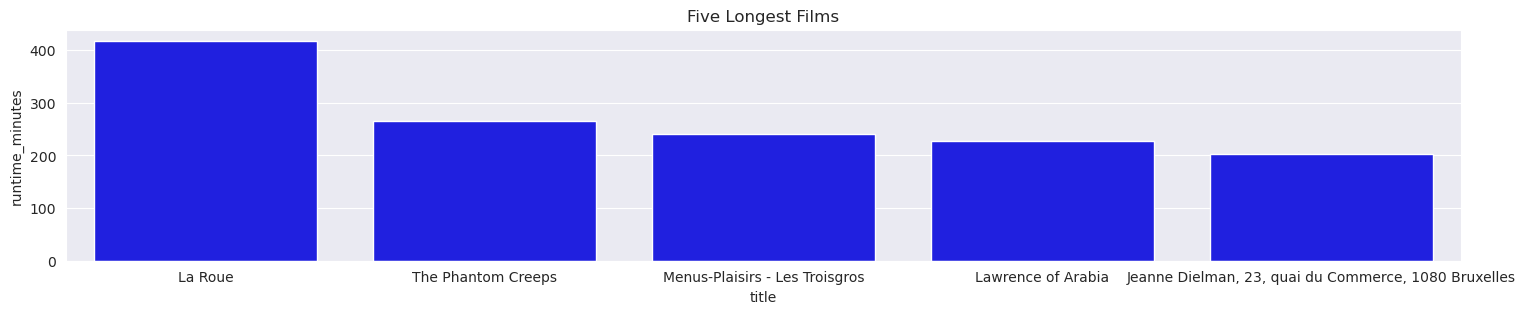

In [300]:
# 1. Longest films
df_sorted = df.sort_values(by='runtime', ascending=False)
df['runtime_minutes'] = df['runtime'].apply(lambda x: x.total_seconds() / 60)

plt.figure(figsize=(18,3))
with sns.axes_style('darkgrid'):
    ax = sns.barplot(data=df_sorted.head(5), x='title', y='runtime_minutes', color='blue')
    ax.set_title('Five Longest Films')

The above plot shows the five films with the longest runtimes. The longest film --- La Roue, which is nearly 7 hours long --- is over an hour longer than the second longest film. All five films are considered cinematic landmarks in their respective genres or for their unique contributions to film history. They are typically characterized by slow, methodicle pacing.

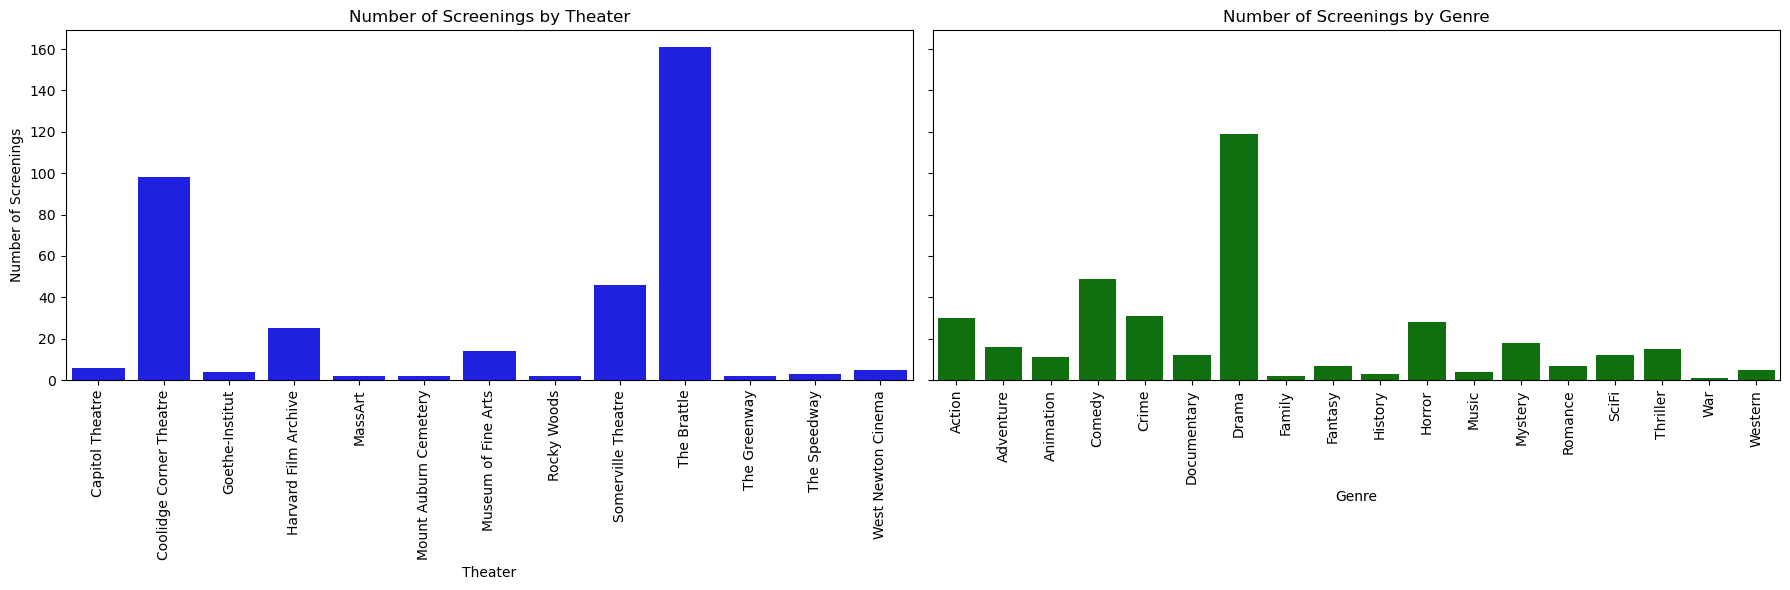

In [301]:
# 2. Screenings by theater & screenings by genre

# get theater and genre counts
theater_counts = df.groupby('theater').size().reset_index(name='num_screenings')
genre_counts = df.groupby('genre').size().reset_index(name='num_screenings')

# create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Plot # of screenings by theater
sns.barplot(data=theater_counts, x='theater', y='num_screenings', ax=axes[0], color='blue')
axes[0].set_title('Number of Screenings by Theater')
axes[0].set_xlabel('Theater')
axes[0].set_ylabel('Number of Screenings')
axes[0].tick_params(axis='x', rotation=90)

# Plot # of screenings by genre
sns.barplot(data=genre_counts, x='genre', y='num_screenings', ax=axes[1], color='green')
axes[1].set_title('Number of Screenings by Genre')
axes[1].set_xlabel('Genre')
axes[1].tick_params(axis='x', rotation=90) 

# Show the plots
plt.tight_layout()
plt.show()

A few theaters dominate in terms of the number of screenings, particularly The Brattle and Coolidge Corner Theatre, which show over 100 and 150 screenings, respectively. The other theaters have significantly fewer screenings, most in the range of 20 or fewer. I can think of two explanations for this discrepancy. First, it could be because these two theaters are in higher demand --- they are located in busy metropolitan areas --- so they put on more films in the span of a given month. Second, and more likely, it could be because screenboston primarily reports old films, and the Brattle and Coolidge Corner specialize in those. The other movie theaters, like Capitol Theatre, put on lots of types of movies, which don't get reported.Drama has the highest number of screenings. This makes sense given that our sample contains mostly old movies, of which very few fall into these alternative categories like animation, fantasy, scifi, etc.


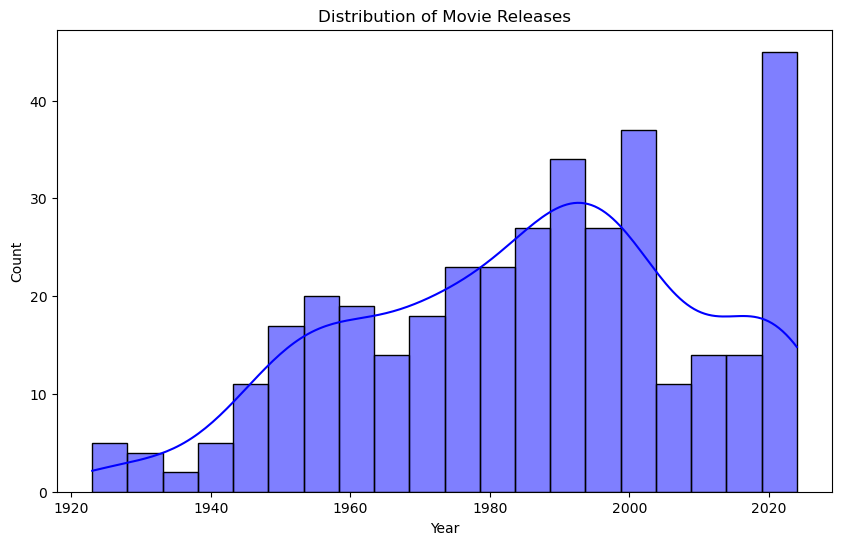

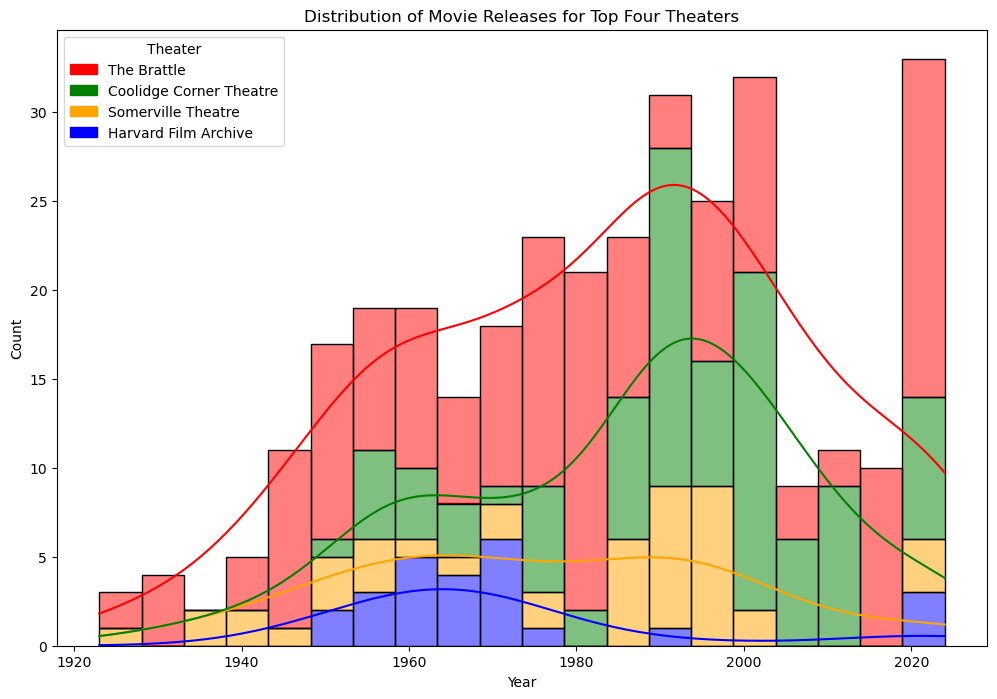

In [308]:
# 3. Year distribution & distribution of year by theater
# Plot (a): histogram of 'year'
plt.figure(figsize=(10, 6))
sns.histplot(df['year'], kde=True, bins=20, color='blue')
plt.title('Distribution of Movie Releases')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

# Plot (b): histogram of 'year' grouped by theater for top four theaters
def top_n(n): return df['theater'].value_counts().nlargest(n).index
mask = df['theater'].isin(top_n(4))

plt.figure(figsize=(12, 8))
colors = {'The Brattle': 'red', 'Coolidge Corner Theatre': 'green', 'Somerville Theatre': 'orange', 'Harvard Film Archive': 'blue'}
sns.histplot(data=df[mask], x='year', hue='theater', multiple='stack', kde=True, bins=20, palette=colors)
plt.title('Distribution of Movie Releases for Top Four Theaters')
plt.xlabel('Year')
plt.ylabel('Count')
handles = [plt.Rectangle((0,0),1,1, color=colors[theater]) for theater in colors] # manually create the legend
plt.legend(handles, colors.keys(), title='Theater', loc='upper left')
plt.show()

From both datasets, it is clear that there is a preference for screening older films. Indeed, the distribution almost seems bimodal. Very few films were released between 2000 and 2020, which suggests that theaters either show old movies or they show new releases. This makes sense --- people either want to watch the best films ever created in history or they want to watch the newest blockbuster.

In addition, certain theaters have different time period specialties. The Coolidge Corner Theater, for instance, clearly specializes in films that range from 1980 to 2000, whereas the Harvard Film Archive specializes in films that range from 1950 to 1970. Given the archival nature of the Harvard Film Archive, this older skew makes sense.

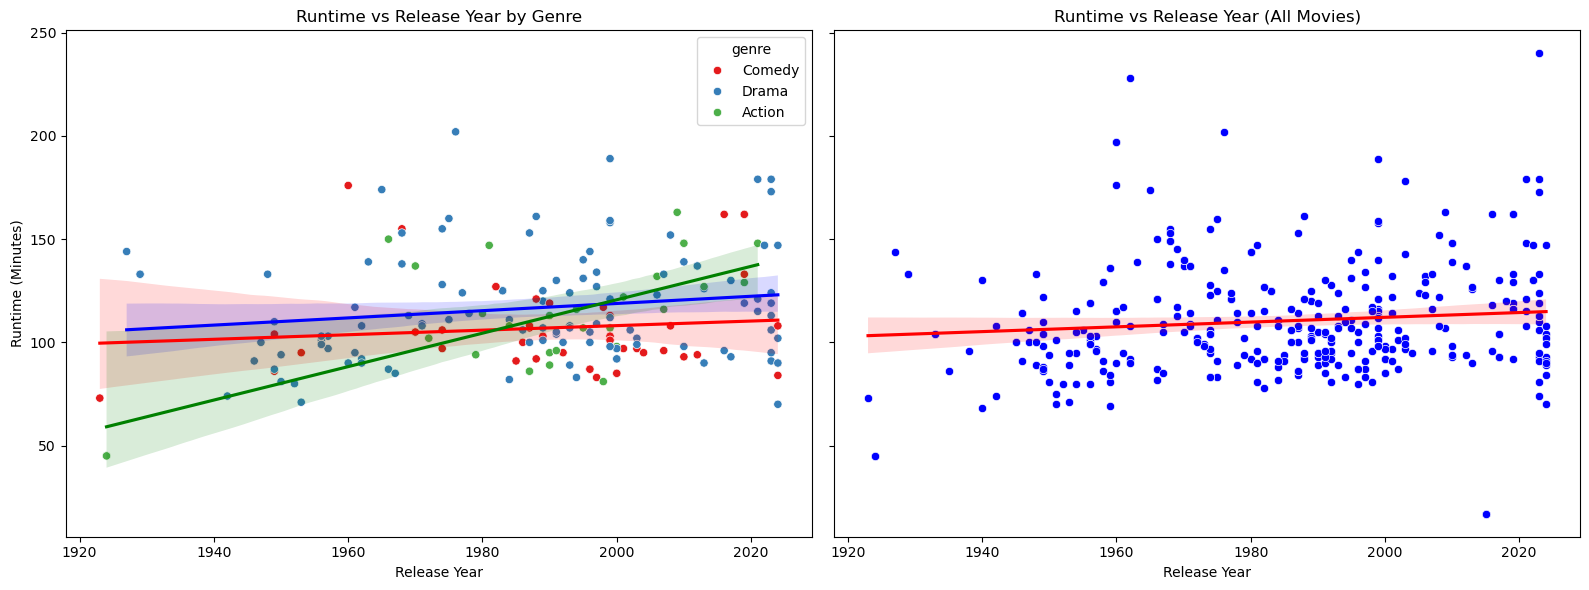

In [309]:
# 4.1 Custom question 1

# filter outliers
df_trimmed = df[df['runtime_minutes'] <= 250]
df_filtered = df_trimmed[df_trimmed['genre'].isin(['Comedy', 'Drama', 'Action'])]

# create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Scatterplot with top 3 genres
sns.scatterplot(data=df_filtered, x='year', y='runtime_minutes', hue='genre', palette='Set1', ax=axes[0])
sns.regplot(data=df_filtered[df_filtered['genre'] == 'Comedy'], x='year', y='runtime_minutes', scatter=False, color='red', ax=axes[0])
sns.regplot(data=df_filtered[df_filtered['genre'] == 'Drama'], x='year', y='runtime_minutes', scatter=False, color='blue', ax=axes[0])
sns.regplot(data=df_filtered[df_filtered['genre'] == 'Action'], x='year', y='runtime_minutes', scatter=False, color='green', ax=axes[0])

axes[0].set_title('Runtime vs Release Year by Genre')
axes[0].set_xlabel('Release Year')
axes[0].set_ylabel('Runtime (Minutes)')

# Second subplot: Scatterplot with all movies, no genre segregation
sns.scatterplot(data=df_trimmed, x='year', y='runtime_minutes', ax=axes[1], color='blue')
sns.regplot(data=df_trimmed, x='year', y='runtime_minutes', scatter=False, color='red', ax=axes[1])
axes[1].set_title('Runtime vs Release Year (All Movies)')
axes[1].set_xlabel('Release Year')

# Set shared y-axis label
axes[0].set_ylabel('Runtime (Minutes)')

# Adjust layout
plt.tight_layout()
plt.show()

Question: Are newer films longer, on average, than older films?

Approach: Graph the relationship between year and runtime. 

The two plots above show the relationship between the year the movie was released and the duration of the film. Overall, the length of movies have slightly trended upwards. This could be because digital film allows for a more flexible approach to runtime, as there's no longer the physical limitations of film reels. In addition, this uptick seems to be in large part due to the emergence of action movies, which thrive on long extended car chases and action shots.

Note: I have dropped outliers --- movies with runtimes outside the 95th percentile --- to more accurately reflect the core trend.



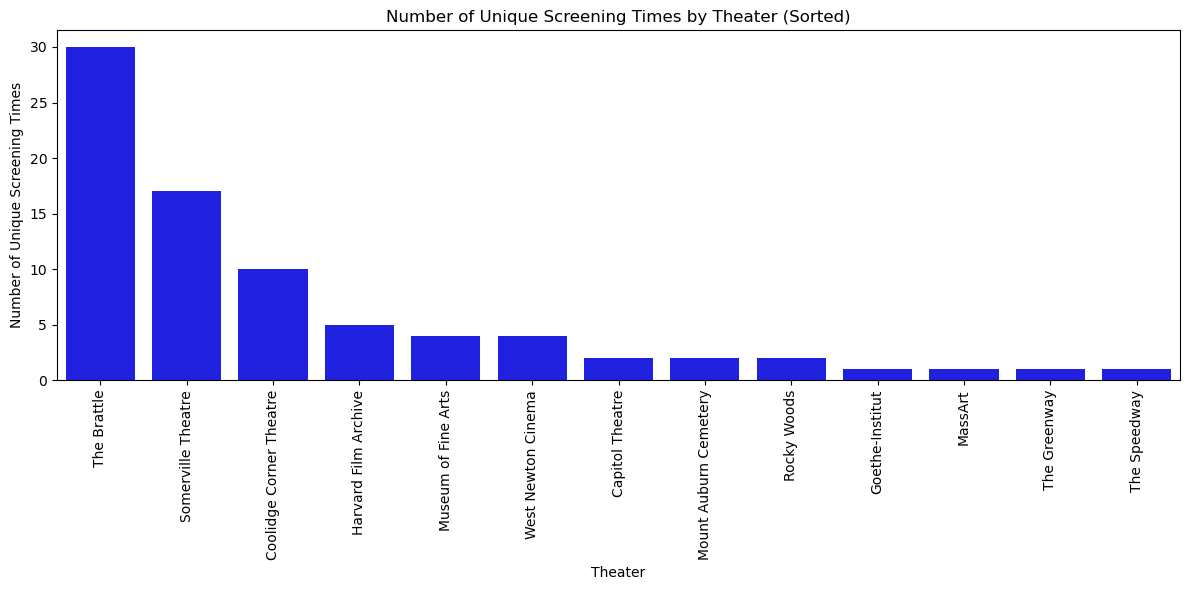

In [311]:
# 4.2 Custom question 2

# count the number of unique screening times for each theater
theater_screenings = df.groupby('theater')['screen_times'].nunique().reset_index().sort_values(by='screen_times', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=theater_screenings, x='theater', y='screen_times', color="blue")
plt.title('Number of Unique Screening Times by Theater (Sorted)')
plt.xlabel('Theater')
plt.ylabel('Number of Unique Screening Times')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Question: Which theaters have the most different screening times?

Approach: Bar plot in descending order

The above plot shows the number of unique screening times for each theater. The theaters with the most number of different screening times are The Brattle, Somerville Theatre, and Collidge Corner Theatre. Unsurprisingly, these are also the theaters that show the most number of films total. This suggests that the two variables are correlated, which makes sense, given that the more films you show, the more different times you need to show those films.


<div class=md>
    <h3>6. Get a film's Wikipedia page identifier</h3>

The screenboston page has relatively little information about each film.  But we can use some of the what we *do* know about each film to query Wikipedia for additional data.
<div class=prompt>
    
  Find a unique identifier for the Wikipedia page for each film and store it in a new 'wiki_id' column. This could be the URL itself or a unique page ID that will allow you to recover the URL. Display the head of your updated DataFrame and describe your approach. You should strive to find page identifiers for as many films as possible, but don't worry if you can't find them all. Shoot for at least 50%.
</div>

**Hints:**
- One way to do this is to construct a query string to that can be appended to wikipeda's search URL:<br>
<code>'https://en.wikipedia.org/w/index.php?search='`</code><br>
You could use movie info from your DataFrame to construct the query string. This could include the title, year, the fact that it is a film, etc. A unqiue identifier such as a URL or page ID can then be extracted from the approapriate search. 
- Feel free to explore wikipedia's API options as an alternative using the search URL.
- Depending on your implementation, this process could take anywhere from a few seconds to a few minutes. To avoid unnecessary requests (and waiting) you should once again write your results to a file and only make requests if this file does not already exist. This point won't be repeated any more in this assignment but you should follow this principle whenever possible to avoid repeating any long tasks or computations.
- Most of the time taken by a request is spend waiting for a response. Asynchronous requests allow you to initiate new requests without having to wait for the previous one to be returned. You can explore the asyncio and aiohttp libraries (imported above) if you'd like to optimize your code for speed. Just be warned that these are very deep topics in themselves so this should really just be an optimization step for the curious. To complicate matters, asyncio works slightly differently in Jupyter notebooks than in Python scripts. Finally, making too many requests too quickly can cause some to fail or may even result in your IP being temporarily blocked by a server.

</div>

In [376]:
from concurrent.futures import ThreadPoolExecutor

search_url = "https://en.wikipedia.org/w/api.php"

# get url for a given query
def search_wikipedia(title, year):
    
    query = f"{title} {year} film"
    params = {
        "action": "query",
        "list": "search",
        "srsearch": query,
        "format": "json",
    }
    response = requests.get(search_url, params=params)
    if response.status_code != 200:
        return np.nan
    
    data = response.json()

    # Check if there are search results
    if data['query']['search']:
        # Get the title of the first search result
        page_title = data['query']['search'][0]['title']
        # Build the full url
        page_url = f"https://en.wikipedia.org/wiki/{page_title.replace(' ', '_')}"
        return page_url
    else:
        # Return NaN if no results were found
        return np.nan

# seed = 1234
# sample = df.sample(10, random_state=seed)

df["wiki_id"] = df.apply(lambda row: search_wikipedia(row['title'], row['year']), axis=1)

In [377]:
# Display results of updated df
missing_rows = df[df.wiki_id.isna()]
num_wiki_id_na = missing_rows.shape[0]
print("Number of screenings missing a wiki ID:", num_wiki_id_na)
if num_wiki_id_na > 0:
    print("Example rows with missing wiki ID")
    display.display(missing_rows)

Number of screenings missing a wiki ID: 0


Approach: use Wikipedia API to build a search query and get the search results. Just using the search URL does not let me do that. Then, get first result, if there is no match and results are returned. (The first result is most likely correct.) If there are no good results, fill with NaN. Then, build a wikipedia URL using the title of the first search result to get the page.


In [380]:
grader.check("q6")

q6 results: All test cases passed!

<div class='md'>
    
<h3>7. Acquire HTML from wiki page and store in DataFrame</h3>

<div class=prompt>
    
Use `'wiki_id'` to acquire the HTML content of each film's Wikipedia page and store it in a new column called `'wiki_html'`.
</div>
</div>

In [386]:
# your code here
def scrape_wiki(link):
    response = requests.get(link)
    response.encoding = 'utf-8'
    if response.status_code != 200:
        return np.nan
    return response.text

df["wiki_html"] = df.apply(lambda row: scrape_wiki(row["wiki_id"]), axis=1)

In [388]:
# Display results of updated df
missing_rows = df[df.wiki_html.isna()]
num_wiki_html_na = missing_rows.shape[0]
print("Number of screenings missing wiki HTML:", num_wiki_html_na)
if num_wiki_html_na > 0:
    print("Example rows with missing wiki HTML")
    display.display(missing_rows)

Number of screenings missing wiki HTML: 0


In [389]:
grader.check("q7")

q7 results: All test cases passed!

<div class=md>

<h3>8. Adding Data from Wikipedia and Asking New Questions</h3>

Now that we have Wikipedia pages for most or all of our movies, we can add supplemental data from those pages to our DataFrame, ask new questions, and use Pandas and visualizations to try and get some answers. This final section is very open-ended, and you are encouraged to experiment. We want to see what you can do!

<div class='prompt'>

1. **Data Extraction and Integration**
   - Extract at least one new piece of data from each movie page you found.
   - Add this data as a new column(s) to your DataFrame.
   - Display the head of your updated DataFrame.
   - Discuss your strategy for extracting the new data, including any challenges you faced and how you overcame them.

2. **Data Analysis and Visualization**
    - Formulate at least two new questions that involve the Wikipedia data you've added.
    - For each question:
      - Clearly state your question and why it's interesting or relevant.
      - Describe your approach to answering the question.
      - Use Pandas to manipulate and analyze the data as needed.
      - Create at least one meaningful visualization that helps answer your question.
      - Ensure your plots are well-labeled and easy to interpret.
      - Interpret the results of your analysis, discussing any insights, patterns, or surprises you discovered.

</div>

**Hints:**
- The 'info box' on the right side of most Wikipedia pages is fairly standardized across film pages. This might be the easiest place to start.
- Some potential pieces of data to extract include the language of the film, its box office revenue or budget, the starring cast, etc.
- Feel free to extract more than just a single new piece of data to use in your analysis. If you're feeling particularly adventurous, you can even jump from the film page to other linked pages to acquire more data!
- Consider how the new data you've extracted might relate to the screening information you already have. Are there interesting connections or patterns to explore?

Remember, the goal is to demonstrate your ability to ask insightful questions, use appropriate data science techniques to answer them, and effectively communicate your findings.
</div>

In [530]:
# get revenue for each movie from the HTML
def get_revenue(html):
    
    soup = BeautifulSoup(html, "html.parser")
    
    infobox = soup.find("table", class_="infobox vevent")     # get infobox

    if infobox:
        rows = infobox.find_all("tr")         # get rows
        for row in rows:                # iterate through rows to find one with header "Box Office"
            header = row.find("th")
            if header and "Box office" in header.text:
                revenue = row.find("td", class_="infobox-data").text.strip() # get text of td with class "infobox-data"
                return revenue

def process_revenue(revenue):
    pattern = r'(?:\$|£)?(\d{1,6}(?:,\d{3})*(?:\.\d+)?)'
    if revenue:
        revenue = revenue.replace(",", "")
        if "million" in revenue:
            number = float(re.search(pattern, revenue).group(1)) * 1000000
        elif "billion" in revenue:
            number = float(re.search(pattern, revenue).group(1)) * 1000000000
        else:
            number = float(re.search(pattern, revenue).group(1))
        return number / 1000000
    return np.nan

df["revenue"] = df.apply(lambda row: get_revenue(row["wiki_html"]), axis=1)
df["revenue_processed"] = df.apply(lambda row: process_revenue(row["revenue"]), axis=1)

In [553]:
from fredapi import Fred

# pull in CPI data from FRED
API_KEY = "030f8842765f5a95241d29401f88429f"
fred = Fred(api_key=API_KEY)
cpi_df = pd.DataFrame(fred.get_series('CPIAUCSL'), columns=['cpi']) 
cpi_df['date'] = pd.to_datetime(cpi_df.index)
cpi_df = cpi_df.resample('YE', on='date').mean() # aggregate to yearly
cpi_df['year'] = cpi_df.index.year
cpi_df = cpi_df.reset_index()
base = 312.513

# filter movie to only include movies released after 1947 and movies that have revenue listed
df_filtered = df[(df["year"] >= 1947) & (~df["revenue_processed"].isna())]
df_filtered.drop(columns=['wiki_html'], inplace=True)

# merge in CPI
df_merged = pd.merge(df_filtered, cpi_df[['year', 'cpi']], on='year', how='left')
df_merged['revenue_adj'] = df_merged['revenue_processed'] * (base / df_merged['cpi'])

/var/folders/9c/7d5d4vv50tlg0qp7ks_m2mtc0000gn/T/ipykernel_31379/1103405725.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop(columns=['wiki_html'], inplace=True)


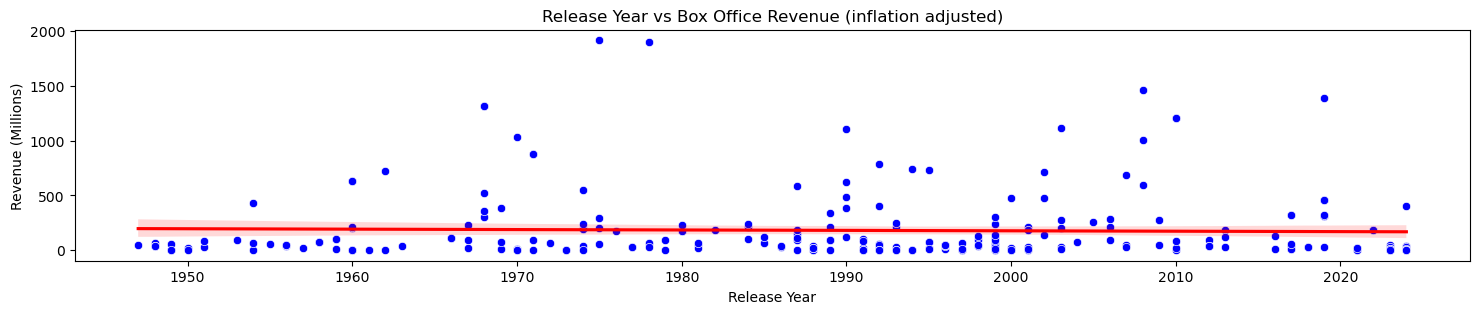

In [556]:
# 2. Data Analysis and Visualization

# drop outliers (movies greater than 2000 million (or 2 billion))

mask = df_merged["revenue_adj"] < 2000

# scatterplot of release year vs inflation adjusted revenue
plt.figure(figsize=(18,3))
sns.scatterplot(data=df_merged[mask], x='year', y='revenue_adj', color='blue')
sns.regplot(data=df_merged[mask], x='year', y='revenue_adj', scatter=False, color='red')
plt.title('Release Year vs Box Office Revenue (inflation adjusted)')
plt.xlabel('Release Year')
plt.ylabel('Revenue (Millions)')
plt.show()

For this final exploratory data analysis, I wanted to see if movies have made more money over time, adjusting for inflation. This is interesting because it helps gauge the size of the movie industry and whether demand for movies has increased over time. My approach was to create a scatterplot to see if, on average, revenues increase year over year.

Turns out, the results of my scatterplot show that, despite Americans being online more than ever, box office revenue has been relatively constant, after adjusting for inflation. This could be due to the growth of the streaming industry, which is an alternative way of viewing movies.


<div class="alert alert-info" style="color: #4a4a4a; background-color: #fbe8ff; border-color: #eed4db; border-width: 1px; border-radius: 3px; padding: 10px;">

**Wrap-up**

* Please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation. This is also a good place to ask any remaining questions you may have.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

</div>

The hardest part of the assignment was definitely scraping all the wayback machine archives. This was incredibly tedious and took hours to troubleshoot -- I still don't have the same number of movies in my dataframe as my friends do (off by about 5 or so, I think -- I have 505 movies pre-cleaning; I'm supposed to have 510), despite the fact that my approach clearly works. Dealing with APIs is always annoying as well.


In [390]:
hours_spent_on_hw = 10

In [ ]:
grader.check("wrapup")

In [ ]:
notebook_end = time.time()
print(f"It took {(notebook_end - notebook_start)/60:.2f} minutes for this notebook to run")

🌈 **This concludes HW1. Thank you!**